In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
# dataset of names
words = open("names.txt", "r").read().splitlines()

In [5]:
chars = sorted(list(set(''.join(words))))
# mapping for a-z --> 1-27
char_to_idx = {s:i+1 for i,s in enumerate(chars)}
# mapping for special character . --> 0
char_to_idx['.'] = 0
# reverse mapping
idx_to_char = {i:s for (s, i) in char_to_idx.items()}



In [7]:
# 27x27 matrix of bigrams in the dataset
N = torch.ones((27, 27), dtype=torch.float32)
for w in words:
    # adding special characters to the word
    chars = ['.'] + list(w) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        idx1, idx2 = char_to_idx[char1], char_to_idx[char2]
        N[idx1, idx2] += 1 

# probabilities matrix - sum over every row = 1
P = N / N.sum(1, keepdim=True)


In [59]:
g = torch.Generator().manual_seed(123)

# sampling names from the matrix
for i in range(10):
    out = []
    # starting index = "." at the beginning of every name
    ix = 0

    while True:
        # choosing row with ix as the first char of bigram
        p = N[ix]
        # sampling one char from p
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        # appending to the current name
        out.append(idx_to_char[ix])
        # breaking the loop, if final character is used
        if ix == 0:
            break
    
    print("".join(out[:-1]))

ldlyahahi
icaton
moresan
dya
coke
ssana
ry
nahikneeyzatan
mele
k


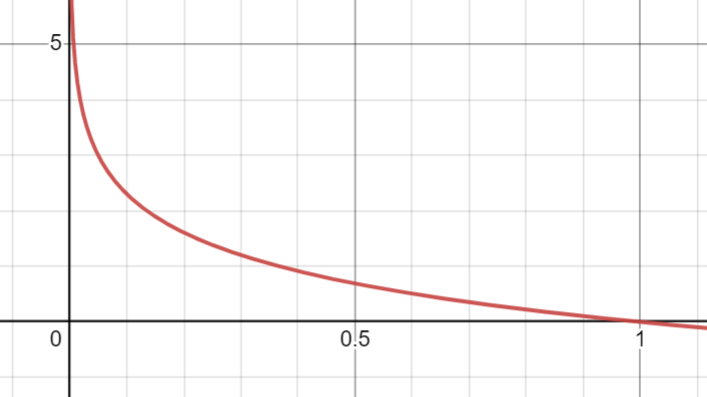

Alternatively likelihood could be used P(A) * P(B) * P(C), but the numbers would be too small

Log-likelihood uses following property of logarithms log(P(A) * P(B) * P(C)) = log(P(A)) + log(P(B)) + log(P(C))

In [20]:
n = 0
prob = 0

# calculating negative log-likelihood --> error for regression
for w in words:
    chars = ['.'] + list(w) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        n += 1
        x1, x2 = char_to_idx[char1], char_to_idx[char2]
        # adding up the negatives (positive) log values of probabilities
        prob += -1 * torch.log(P[x1, x2])
# averiging over the number of bigrams in the dataset
print((prob) / n)

tensor(2.4544)


In [21]:
# initializing a weight matrix
W = torch.randn((27,27), generator=g, requires_grad = True)
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        x1, x2 = char_to_idx[ch1], char_to_idx[ch2]
        xs.append(x1)
        ys.append(x2)

# xs contain all first characters
xs = torch.tensor(xs)
# ys contain all second characters of a bigram --> labels
ys = torch.tensor(ys)
# number of datapoints
num = xs.nelement()

In [36]:
# training a one layer NN
for _ in range(10):
    # one-hot encoding for integer values as inputs to NN. Array of all 0s except one 1 --> index of the element
    xenc = F.one_hot(xs, num_classes = 27).float()
    
    # weighted inputs matmul, num x 27 @ 27 x 27 = num x 27
    logits = xenc @ W
    
    # logits may be negative (some weights are negative)
    # turning all logits positive - due to monotony of exp they become equivalent to the counts used in bigram matrix
    logits_exp = logits.exp()
    # normalizing - softmax layer, sum of one row = 1
    probs = logits_exp / logits_exp.sum(1, keepdims=True)
    
    # negative log-likelihood
    # rows of probs are all the inputs to the NN, ys are desired outputs. We calculate the mean of them - average error per entry
    loss = -probs[torch.arange(num), ys].log().mean()
    print(loss.item())
    # setting gradients to 0
    W.grad = None
    # backpropagating the error
    loss.backward()
    # updating the weights
    W.data += -20 * W.grad

2.461514472961426
2.461498498916626
2.461482524871826
2.4614663124084473
2.4614505767822266
2.461434841156006
2.461418867111206
2.4614033699035645
2.4613873958587646
2.461371660232544


In [61]:
# sampling names from the NN
for i in range(10):
    out = []
    # starting index = "." at the beginning of every name
    ix = 0

    while True:
        # choosing row with ix as the first char of bigram --> 1x27 vector of all 0s and one 1
        xenc = F.one_hot(torch.tensor([ix]), num_classes = 27).float()

        # by multiplying weights with xenc, we basically extract the one corresponding row from W
        logits = xenc @ W
        
        # turning all logits positive - monotonic equivalent to the counts
        counts = logits.exp()
        # normalizing - softmax
        p = counts / counts.sum(1, keepdims=True)  
        
        # sampling one char from p
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        # appending to the current name
        out.append(idx_to_char[ix])
        # breaking the loop, if final character is used
        if ix == 0:
            break
    
    print("".join(out[:-1]))

stovatdysad
e
dyn
fruaigird
leyveveshaleseyngeka
dah
xxtoonini
miinenelisa
de
azaylerietonbilelevotikin


### MLP

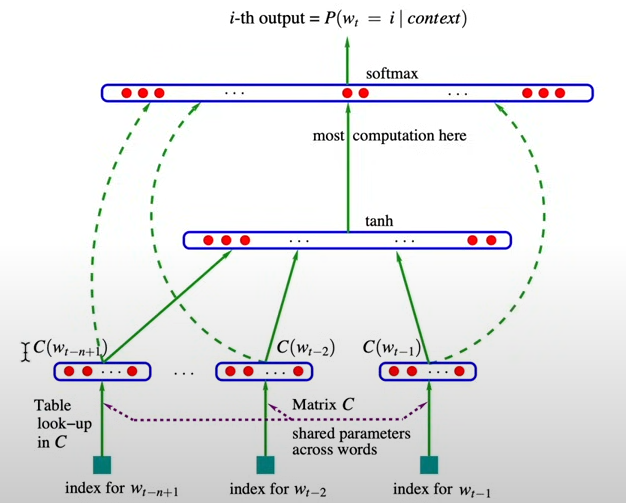

### roughly the layout
- blocksize 3 (3 inputs)
- embedding for all 3 of them
- "connecting them to a single vector
- tanh NN layer
- softmax layer

In [51]:
# creating many datapoints, where input are 1 * blocksize characters and Y is the following character
# there are much more datapoints than words (5 letter word using blocksize 3 --> 6 datapoints)

# 3 characters array is X - Y is the 4th in the row
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size # 0 = special character "."
    
        for char in w + ".":
            ix = char_to_idx[char]
            X.append(context)
            Y.append(ix)
            # adjusting the context "adam" --> "...", "..a", ".ad", ...
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y
    
random.seed(42)
random.shuffle(words)

# indexes for the three datasets 0.8/0.1/0.1
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [80]:
g = torch.Generator().manual_seed(2147483647)

n_embeddings = 10
n_hidden = 200
vocab_size = 27

# embedding for each letter (27) consisting of 10 values
C = torch.randn((vocab_size, n_embeddings))
# weights from input to 1st layer. 
W1 = torch.randn((n_embeddings * block_size, n_hidden))
# biases 1st layer
b1 = torch.randn(n_hidden)

# weights + biases to the output layer --> 27 characters
W2 = torch.randn((n_hidden, vocab_size))
b2 = torch.randn(vocab_size)

batch_normal_gain = torch.ones((1, n_hidden))
batch_normal_bias = torch.zeros((1, n_hidden))


parameters = [C, W1, b1, W2, b2]

In [53]:
for p in parameters:
    p.requires_grad = True

In [79]:
# training the NN
for _ in range(50000):
    # creating a minibatch of size 32 - random indexes from Xtr
    ix = torch.randint(0, len(Xtr), (32,))
    # getting the embedding 32 (minibatch size) x 3 (each letter of the NN input) x 10 (embedding size)
    emb = C[Xtr[ix]]

    # calculating activations of the first layer
    # view changes the emb to 32 x 30
    # applying tanh on the multiply of embedding @ weights + bias
    z = emb.view(-1, 30) @ W1 + b1
    z = batch_normal_gain * (z - z.mean(0, keepdim=True)) / z.std(0, keepdim=True) + batch_normal_bias
    activations = torch.tanh(z)
    # raw values before the output layer
    logits = activations @ W2 + b2
    # cross-entropy loss function
    loss = F.cross_entropy(logits, Ytr[ix])
    
    for p in parameters:
        # reseting grad
        p.grad = None
    loss.backward()
    for p in parameters:
        # updating all parameters by the gradient
        p.data += -0.01 * p.grad

tensor([[ 0.9521,  0.6657, -0.7959,  ...,  0.0808,  0.5886,  0.1747],
        [ 0.9464, -0.8609,  0.9832,  ..., -0.9810,  0.3748,  0.7987],
        [-0.4616,  0.7646, -0.3888,  ..., -0.8280,  0.1228, -0.1192],
        ...,
        [ 0.3112, -0.8123, -0.3805,  ...,  0.3733,  0.3484, -0.8624],
        [-0.6675,  0.6022,  0.9776,  ...,  0.3149, -0.7950, -0.4681],
        [-0.4612, -0.5779,  0.6780,  ...,  0.9579,  0.7334,  0.1976]],
       grad_fn=<TanhBackward0>)


In [69]:
# loss on developer data (hyperparameters finetuning)
emb = C[Xdev]
activations = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = activations @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4999, grad_fn=<NllLossBackward0>)

In [64]:
# loss on training data
emb = C[Xtr]
activations = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = activations @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4724, grad_fn=<NllLossBackward0>)

In [70]:
# loss on test data
emb = C[Xte]
activations = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = activations @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.4964, grad_fn=<NllLossBackward0>)

In [73]:
# sampling names from the NN
for i in range(10):
    out = []
    # starting context = "..." at the beginning of every name
    context = [0] * block_size

    while True:
        # embedding for context
        emb = C[torch.tensor(context)]
        activations1 = torch.tanh(emb.view(-1, 30) @ W1 + b1)
        activations2 = activations1 @ W2 + b2
        probs = F.softmax(activations2, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        out.append(idx_to_char[ix])
        context = context[1:] + [ix]
        if ix == 0:
            break
    
    print("".join(out[:-1]))
print(probs)

bran
leea
kasri
mayloralyni
rolyw
caylee
avins
davrua
coneonhia
waelya
tensor([[2.3892e-01, 2.1183e-03, 5.9380e-04, 5.9331e-03, 9.9363e-03, 7.0964e-03,
         1.2070e-04, 4.6928e-03, 3.5285e-02, 1.4833e-03, 7.5690e-05, 2.4911e-02,
         3.7476e-02, 3.5752e-02, 4.6141e-01, 9.8853e-04, 6.4623e-05, 2.9388e-08,
         3.6155e-04, 7.4088e-02, 7.5122e-04, 9.3722e-05, 3.9912e-05, 1.6970e-04,
         8.6456e-12, 5.7596e-02, 3.7732e-05]], grad_fn=<SoftmaxBackward0>)
